<a href="https://colab.research.google.com/github/ddavis-2015/OpenAI-Gym-Challenges/blob/master/cartpole-dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install additional software

These packages are needed to render animations for the OpenAI Gym environment.

Some OpenAI Gym environments will not run without these packages installed even when not rendering animations.

Packages must be installed in the order shown to avoid dependancy problems between pyglet and gym.

In [6]:
!apt-get install -qq -y xvfb
!pip install gym
!pip install pyglet
!pip install pyopengl
!apt-get install -qq x11-utils 
!pip install pyvirtualdisplay
!pip install box2d-py

Selecting previously unselected package xvfb.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 145612 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../x11-utils_7.7+3build1_amd64.deb ...
Unpacking x11-utils (7.7+3build1) ...
Setting up libxxf86dga1:amd64 (2:1.1.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up x11-utils (7.7+3build1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
     |████████████████████████████████| 450kB 6.3MB/s 


# Deep Q Network model for reinforcement learning


In [2]:
# -*- coding: utf-8 -*-
import random
import gym
import numpy as np
from tensorflow import keras
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

EPISODES = 1000
MAXSTEPS = 450
DENSE_NODES = 6

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.90    # discount rate
        self.epsilon = 1.0  # exploration rate (greedy epsilon)
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.980
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(DENSE_NODES, input_dim=self.state_size, activation='relu'))
        model.add(Dense(DENSE_NODES, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, use_epsilon=True):
        if use_epsilon and (np.random.rand() <= self.epsilon):
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action index

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=10, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


Using TensorFlow backend.


# Training Loop

The task is attempted a certain number of **EPISODES**

Each attempt has up to **MAXSTEPS** actions taken

The model is saved on each succesful attempt (reaching **MAXSTEPS** actions)

A difference from other DQN model examples is that here training only occurs on a failed attempt, using the replay buffer.  This generally uses less training time, whereas training after each action increases training time.

Failures are not penalized.  Instead the goal is simply to maximize the reward by keeping the pole upright for as long as possible.



In [0]:
!mkdir -p save

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    done = False
    batch_size = 64

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(MAXSTEPS + 1):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done or time == MAXSTEPS:
                print("episode: {}/{}, score: {}, e: {:.3}"
                      .format(e, EPISODES, time, agent.epsilon))
                if done and (len(agent.memory) > batch_size):
                    agent.replay(batch_size)
                break

        if time == MAXSTEPS and not done:
            print('***saving***')
            agent.save("./save/cartpole-dqn.h5")

# Function to test the saved model

In [0]:
def test():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    agent.load("./save/cartpole-dqn.h5")
    done = False
    success = 0.0

    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(MAXSTEPS + 1):
            action = agent.act(state, use_epsilon = False)
            next_state, _, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            if done or time == MAXSTEPS:
                if time == MAXSTEPS:
                    success += 1
                if (e + 1) % 20 == 0:
                    print("episode: {}/{}, score: {}, success {:.2f}%".format(e + 1, EPISODES, time, (success / (e+1)) * 100))
                break

# Report GPU availability and run the test of the model

In [0]:
import tensorflow as tf
print(tf.test.gpu_device_name())
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
test()

# Generate an animation for a single test run of the model

Rendering time is longer than real-time (much longer) due to JavaScript code generation.

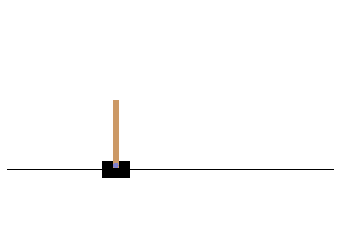

In [6]:
from pyvirtualdisplay import Display
dpy = Display(visible=0, size=(400, 300))
dpy.start()

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

ANIMATION_SECS = 10 # length of animation in seconds

#
# 'done' must be a reference object not a value object or this 
# variable will be garbage collected.  The HTML function and
# FuncAnimation object schedule their work with a timer
# (instead of a co-routine).
#
done = [False]

env = gym.make('CartPole-v1')

frame_rate = env.metadata['video.frames_per_second']
frame_count = ANIMATION_SECS * frame_rate
interval_ms = 1000 / frame_rate

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.load("./save/cartpole-dqn.h5")

state = env.reset()
state = np.reshape(state, [1, state_size])

img = plt.imshow(env.render(mode = 'rgb_array')) # only call this once
plt.axis('off')

def dostep(frame, img, done, agent, state, state_size):
    if done[0]:
        return []

    action = agent.act(state, use_epsilon = False)                
    next_state, _, done[0], _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    np.copyto(state, next_state)

    img.set_data(env.render(mode = 'rgb_array')) # just update the data

    return [img]

ani = animation.FuncAnimation(plt.gcf(),
                              dostep,
                              frames = frame_count,
                              fargs = (img, done, agent, state, state_size),
                              interval = interval_ms,
                              blit = True)

HTML(ani.to_jshtml())
